## Advanced Lane Line Detection

This project deals with determining lane lanes by a series of procedures as follows:
 
- Camera Calibration
- Undistort the image
- Colour and Gradient Threshold
- Perspective Transform
- Identify lane lines by Histogram Peaks
- Silding Window Approach
- Measure the radius of Curvature and Fit the polynomial for Straight and Curvy Lanes.

## Section 1: Camera Calibration

- Images are shown below which are present in the calibration directory.
- Camera Calibration function returns Camera Matrix and Distortion coefficients.
- 9,6 configuration is used to find the checkboard corners.
- cv2.caliberateCamera function is used to find out camera matrix and distortion coefficients.
- Undistort function uses the camera matrix and distortion coefficients to undistrt the image.


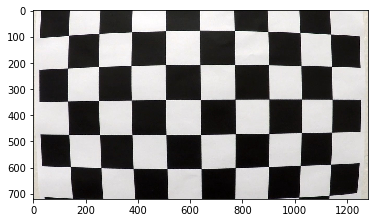

In [26]:
import numpy as np 
import cv2 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob2
from moviepy.editor import VideoFileClip
import math


%matplotlib inline
%matplotlib inline

ex_image = mpimg.imread('camera_cal/calibration1.jpg')

#Example
plt.imshow(ex_image)
plt.show()

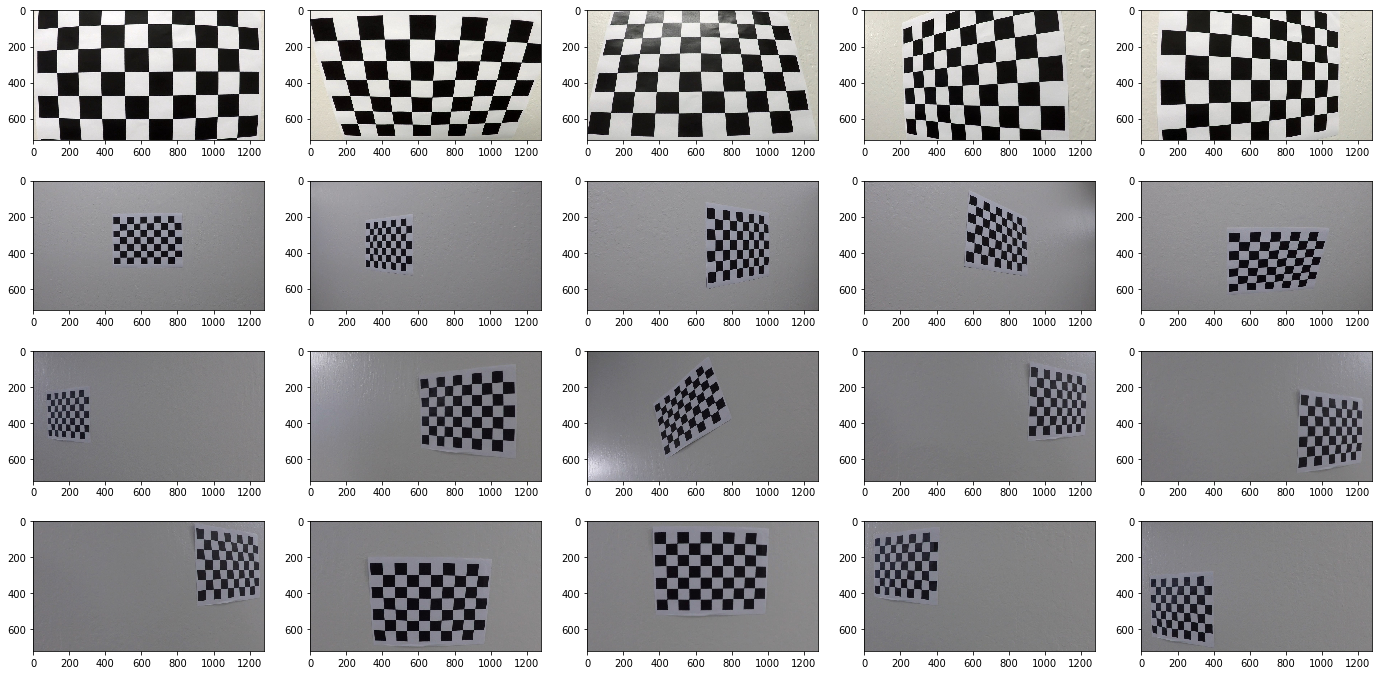

In [27]:
path = ['camera_cal/calibration'+str(i)+'.jpg' for i in range(1,21)]


fig, ax = plt.subplots(4,5)
fig.set_size_inches(24,12)

for i, j in np.ndindex((5,4)):
    ax[j][i].imshow(mpimg.imread(path[j*5+i]))
    
plt.show()


In [28]:

def camera_Calibraton(directory, filename, nx, ny, img_size):
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    objpoints = [] 
    imgpoints = []

    # Image List
    images = glob2.glob('./'+directory+'/'+filename+'*'+'.jpg')

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
    
            
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
        
    return mtx, dist

In [29]:
def undistort(image, mtx, dist):
    image = cv2.undistort(image, mtx, dist, None, mtx)
    return image

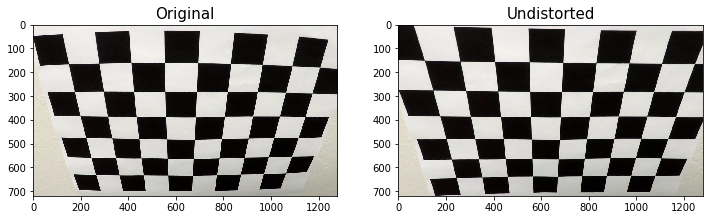

In [30]:
mtx, dist = camera_Calibraton('camera_cal', 'calibration', 9, 6, (720, 1280))
checker_distorted = mpimg.imread("./camera_cal/calibration2.jpg")
checker_undistorted = undistort(checker_dist, mtx, dist)



f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(12, 18))
ax1.imshow(checker_distorted)
ax1.set_title('Original', fontsize=15)
ax2.imshow(checker_undistorted)
ax2.set_title('Undistorted', fontsize=15)

In [31]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Take the derivative in x or y given orient = 'x' or 'y'
    if(orient == 'y'):
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
        
    # Take the absolute value of the derivative or gradient
    sobel = np.absolute(sobel)
    
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    sobel = np.uint8(255*sobel/np.max(sobel))
    
    # Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sbinary = np.zeros_like(sobel)
    sbinary[(sobel >= thresh_min) & (sobel <= thresh_max)] = 1
    
    # Return this mask as your binary_output image
    return sbinary

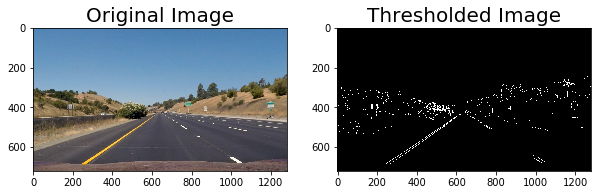

In [32]:
img = mpimg.imread('test_images/straight_lines1.jpg')

thresholded = abs_sobel_thresh(img, orient='x', thresh_min=40, thresh_max=255)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(thresholded, cmap='gray')
ax2.set_title('Thresholded Image', fontsize=20)
plt.savefig('output_images/sobel_x', bbox_inches='tight')
plt.show()

In [33]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    # 3) Calculate the magnitude 
    mag = np.sqrt(sobelx**2+sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    mag = np.uint8(255*mag/np.max(mag))
    # 5) Create a binary mask where mag thresholds are met
    binary = np.zeros_like(mag)
    binary[(mag>=mag_thresh[0]) & (mag<=mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    # Remove this line
    return binary

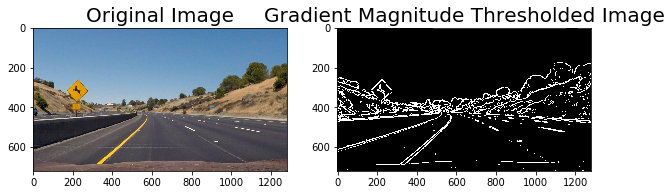

In [34]:
img = mpimg.imread('test_images/test2.jpg')

thresholded = mag_thresh(img, sobel_kernel=9, mag_thresh=(40,255))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(thresholded, cmap='gray')
ax2.set_title('Gradient Magnitude Thresholded Image', fontsize=20)
plt.show()

In [35]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    # 3) Take the absolute value of the x and y gradients
    sobelx = np.absolute(sobelx)
    sobely = np.absolute(sobely)
    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction = np.arctan2(sobely, sobelx)
    
    # 5) Create a binary mask where direction thresholds are met
    binary = np.zeros_like(direction)
    
    # 6) Return this mask as your binary_output image
    binary[(direction>=thresh[0]) & (direction<=thresh[1])] = 1
    
    return binary

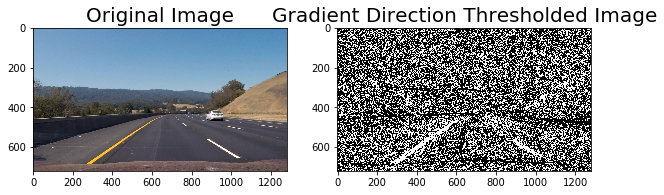

In [36]:
img = mpimg.imread('test_images/test3.jpg')

thresholded = dir_threshold(img, sobel_kernel=9, thresh=(0.7, 1.3))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(thresholded, cmap='gray')
ax2.set_title('Gradient Direction Thresholded Image', fontsize=20)
plt.show()


In [37]:
def apply_threshold(img):
    # X threshold
    gradx = abs_sobel_thresh(img, orient='x', thresh_min=30, thresh_max=100)
    
    # Y threshold
    grady = abs_sobel_thresh(img, orient='y', thresh_min=30, thresh_max=100)
    
    # Magnitude threshold
    mag = mag_thresh(img, sobel_kernel=9, mag_thresh=(30,100))
    
    # Direction threshold
    direction = dir_threshold(img, sobel_kernel=29, thresh=(0.7,1.3))
    
    # Combining All
    binary = np.zeros_like(direction)
    
    binary[((gradx == 1) & (grady == 1))|((mag == 1) & (direction == 1))] = 1
    
    return binary

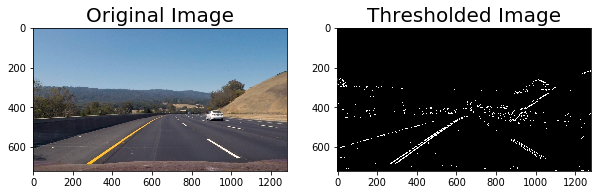

In [38]:
img = mpimg.imread('test_images/test3.jpg')

thresholded = apply_threshold(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(thresholded, cmap='gray')
ax2.set_title('Thresholded Image', fontsize=20)
plt.savefig('output_images/multiple_thresholds', bbox_inches='tight')
plt.show()


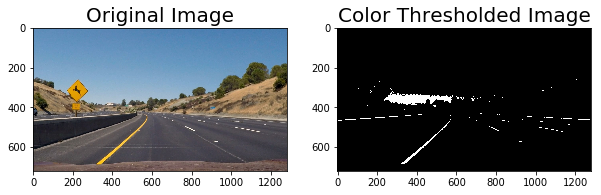

In [39]:
image = mpimg.imread('test_images/test2.jpg')
thresh = (180, 255)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
binary = np.zeros_like(gray)
binary[(gray > thresh[0]) & (gray <= thresh[1])] = 1

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(binary, cmap='gray')
ax2.set_title('Color Thresholded Image', fontsize=20)
plt.savefig('output_images/gray_thresholded', bbox_inches='tight')
plt.show()

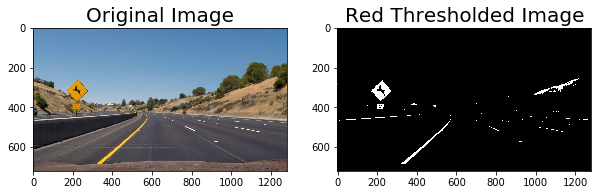

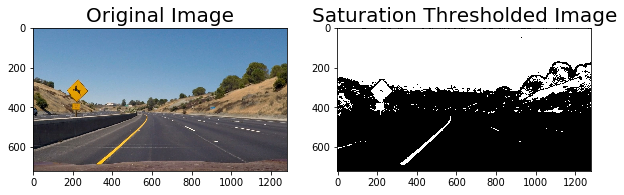

In [40]:
R = image[:,:,0]
G = image[:,:,1]
B = image[:,:,2]

thresh = (200, 255)
binary = np.zeros_like(R)
binary[(R > thresh[0]) & (R <= thresh[1])] = 1

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(binary, cmap='gray')
ax2.set_title('Red Thresholded Image', fontsize=20)
plt.savefig('output_images/red_thresholded', bbox_inches='tight')
plt.show()

hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]
thresh = (90, 255)
binary = np.zeros_like(S)
binary[(S > thresh[0]) & (S <= thresh[1])] = 1

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(binary, cmap='gray')
ax2.set_title('Saturation Thresholded Image', fontsize=20)
plt.savefig('output_images/saturation_thresh', bbox_inches='tight')
plt.show()

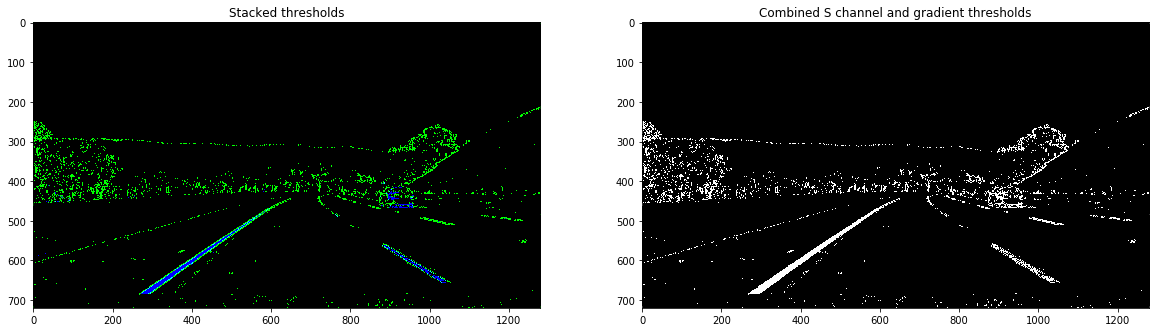

In [41]:
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]

# Grayscale image
# NOTE: we already saw that standard grayscaling lost color information for the lane lines
# Explore gradients in other colors spaces / color channels to see what might work better
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Sobel x
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Threshold x gradient
thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

# Threshold color channel
s_thresh_min = 170
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))*255

# Combine the two binary thresholds
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')
plt.savefig('output_images/combined_gradients', bbox_inches='tight')

In [58]:
def warp(img, src, dst): 
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # get warped image
    warped = cv2.warpPerspective(img, M, img.shape[0:2][::-1], flags=cv2.INTER_LINEAR)
    return warped, Minv



In [52]:
def process_image(img, mtx, dist):
    img = undistort(img, mtx, dist)
    
    src = np.float32([
            [520.847, 450.627],
            [760.153, 450.627],
            [1016.4462, img.shape[0]],
            [263.5538, img.shape[0]]
        ])
    
    dst = np.float32([
            [0, 0],
            [1280, 0],
            [914.638, img.shape[0]],
            [365.362, img.shape[0]]
        ])
    
    img, Minv = warp(img, src, dst)
    
    return img, Minv

In [53]:
def get_rg_thresholded(img,r_thresh=(150,255), g_thresh=(150,255)):
    r=img[:,:,0]
    g=img[:,:,1]
    
    
    b_rg = np.zeros_like(gray)
    b_rg[((r>r_thresh[0])&(r<=r_thresh[1]))&((g>g_thresh[0])&(g<=g_thresh[1]))] = 1
    return b_rg

In [54]:
def get_hs_thresholded(img, h_thresh=(15,100), s_thresh=(90,255), v_thresh=(200,255)):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    h=hsv[:,:,0]
    s=hsv[:,:,1]
    v=hsv[:,:,2]
    
    b_hs = np.zeros_like(h)
    b_hs[((h>h_thresh[0])&(h<=h_thresh[1]))&((s>s_thresh[0])&(s<=s_thresh[1]))&((v>v_thresh[0])&(v<=v_thresh[1]))] = 1
    return b_hs

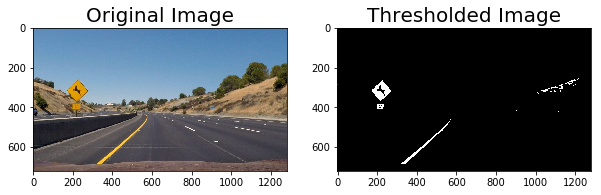

In [55]:
img = mpimg.imread('test_images/test2.jpg')
hs_thresholded = get_hs_thresholded(img, h_thresh=(15,100), s_thresh=(90,255), v_thresh=(200,255))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(hs_thresholded, cmap='gray')
ax2.set_title('Thresholded Image', fontsize=20)
plt.savefig('output_images/hs_thresh', bbox_inches='tight')
plt.show()


In [68]:
def get_grad_thresh(img):
    sobel_kernel = 9
    
    mag_thresh_s = (20,20)
    mag_thresh_l = (20,20)
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    h = hls[:,:,0]
    l = hls[:,:,1]
    s = hls[:,:,2]
    
    sobelx_s = cv2.Sobel(s, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    sobely_s = cv2.Sobel(s, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
   
    mag_s = np.sqrt(sobelx_s**2+sobely_s**2)
    
    mag_s = np.uint8(255*mag_s/np.max(mag_s))
    
    
    sobelx_l = cv2.Sobel(l, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    sobely_l = cv2.Sobel(l, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
   
    mag_l = np.sqrt(sobelx_l**2+sobely_l**2)
    
    mag_l = np.uint8(255*mag_l/np.max(mag_l))
    
    binary = np.zeros_like(mag_s)
    binary[((mag_s>=mag_thresh_s[0]) & (mag_s<=mag_thresh_s[1]))|((mag_l>=mag_thresh_l[0])&(mag_l<=mag_thresh_l[1]))] = 1
    
    return binary
    
    grad_x = abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=255)
    grad_m = mag_thresh(img, sobel_kernel=9, mag_thresh=(20,255))
    grad_d = dir_threshold(img, sobel_kernel=15, thresh=(0.7,1.3))
    
    b_grad = np.zeros_like(grad_x)
    b_grad[((grad_x==1)|(grad_m==1))] = 1
    
    return b_grad

In [69]:
def get_lanes(img):
    b_hs_yellow = get_hs_thresholded(img=img, h_thresh=(15,100), s_thresh=(90,255), v_thresh=(200,255))
    b_hs_white = get_hs_thresholded(img=img,h_thresh=(0,255), s_thresh=(0,40), v_thresh=(220,255))
    
    b = np.zeros_like(b_hs_yellow)
    
    b_grad = get_grad_thresh(img)
    
    b[(b_hs_white == 1)|(b_hs_yellow == 1)|(b_grad==1)] = 1
    
    return b

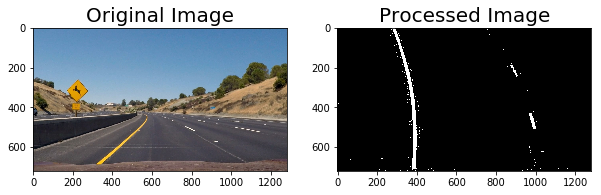

In [70]:
img = mpimg.imread('test_images/test2.jpg')
processed, Minv = process_image(img, mtx, dist)

lines = get_lanes(processed)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(lines, cmap='gray')
ax2.set_title('Processed Image', fontsize=20)
plt.savefig('output_images/binary_warped', bbox_inches='tight')
plt.show()


In [87]:
class lanefinder(object):
    
    def __init__(self):
        self.plot = False
    
    def should_plot(self, plot = False):
        self.frames_processed = 0
        self.plot = plot
        
    def apply_on_video(self, input_video = "project_video.mp4", output_video = "project_video_output.mp4", plot = False):
        self.plot = plot
        
        self.frames_processed = 0
        self.left_fit = None
        self.right_fit = None
        self.out_img = None
        
        # Import everything needed to edit/save/watch video clips
        from moviepy.editor import VideoFileClip
        from IPython.display import HTML

        set_prev = 0
        do_diagnosis = 1

        clip4 = VideoFileClip(input_video);
        white_clip = clip4.fl_image(self.apply_pipeline) #NOTE: this function expects color images!!
        %time white_clip.write_videofile(output_video, audio=False);
        
        HTML("""
        <video width="960" height="540" controls>
          <source src="{0}">
        </video>

        """.format(output_video))
        
    def apply_pipeline(self,img):
        global left_fit
        global right_fit
        global out_img
        
        '''Udistort Image'''
        img = undistort(img, mtx, dist)

        if(self.plot):
            f, ((ax11, ax12),(ax21, ax22)) = plt.subplots(2, 2, figsize=(12, 7))
            ax11.imshow(img)
            ax11.set_title('Undistorted Image', fontsize=20)

        '''Warp Image'''
        src = np.float32([
            [560.847, 445.627],
            [720.153, 445.627],
            [1016.4462, img.shape[0]],
            [263.5538, img.shape[0]]
        ])

        dst = np.float32([
            [0, 0],
            [1280, 0],
            [914.638, img.shape[0]],
            [365.362, img.shape[0]]
            ])

        
        
        
        
            
        warped, Minv = warp(img, src, dst)
        binary_warped = get_lanes(warped)
        
        if(self.plot):
            ax12.imshow(binary_warped, cmap='gray')
            ax12.set_title('Binary Image', fontsize = 20)
        
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        
        window_img=np.zeros_like(out_img)##########################################

        if(self.frames_processed == 0):
            # Find Lines
            # Assuming you have created a warped binary image called "binary_warped"
            # Take a histogram of the bottom half of the image
            histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
            
            # Find the peak of the left and right halves of the histogram
            # These will be the starting point for the left and right lines
            midpoint = np.int(histogram.shape[0]/2)
            leftx_base = np.argmax(histogram[:midpoint])
            rightx_base = np.argmax(histogram[midpoint:]) + midpoint

            # Choose the number of sliding windows
            nwindows = 9
            # Set height of windows
            window_height = np.int(binary_warped.shape[0]/nwindows)
            # Identify the x and y positions of all nonzero pixels in the image
            nonzero = binary_warped.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Current positions to be updated for each window
            leftx_current = leftx_base
            rightx_current = rightx_base
            # Set the width of the windows +/- margin
            margin = 100
            # Set minimum number of pixels found to recenter window
            minpix = 50
            # Create empty lists to receive left and right lane pixel indices
            left_lane_inds = []
            right_lane_inds = []

            # Step through the windows one by one
            for window in range(nwindows):
                # Identify window boundaries in x and y (and right and left)
                win_y_low = binary_warped.shape[0] - (window+1)*window_height
                win_y_high = binary_warped.shape[0] - window*window_height
                win_xleft_low = leftx_current - margin
                win_xleft_high = leftx_current + margin
                win_xright_low = rightx_current - margin
                win_xright_high = rightx_current + margin
                # Draw the windows on the visualization image
                cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
                cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
                # Identify the nonzero pixels in x and y within the window
                good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
                good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
                # Append these indices to the lists
                left_lane_inds.append(good_left_inds)
                right_lane_inds.append(good_right_inds)
                # If you found > minpix pixels, recenter next window on their mean position
                if len(good_left_inds) > minpix:
                    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                if len(good_right_inds) > minpix:        
                    rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

            # Concatenate the arrays of indices
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)

            # Extract left and right line pixel positions
            leftx = nonzerox[left_lane_inds]
            lefty = nonzeroy[left_lane_inds] 
            rightx = nonzerox[right_lane_inds]
            righty = nonzeroy[right_lane_inds] 

            # Fit a second order polynomial to each
            left_fit = np.polyfit(lefty, leftx, 2)
            right_fit = np.polyfit(righty, rightx, 2)

            # Generate x and y values for plotting
            ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        else:
            # Assume you now have a new warped binary image 
            # from the next frame of video (also called "binary_warped")
            # It's now much easier to find line pixels!
            nonzero = binary_warped.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            margin = 100
            left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
            right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

            # Again, extract left and right line pixel positions
            leftx = nonzerox[left_lane_inds]
            lefty = nonzeroy[left_lane_inds] 
            rightx = nonzerox[right_lane_inds]
            righty = nonzeroy[right_lane_inds]
            # Fit a second order polynomial to each
            left_fit = np.polyfit(lefty, leftx, 2)
            right_fit = np.polyfit(righty, rightx, 2)
            # Generate x and y values for plotting
            ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        if(self.plot):
            ax21.imshow(out_img)
            ax21.plot(left_fitx, ploty, color='yellow')
            ax21.plot(right_fitx, ploty, color='yellow')
            ax21.set_title('Polynomials', fontsize = 20)

        # Draw on Image
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
        result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
        
        y_eval = np.max(ploty)
        
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720.0 # meters per pixel in y dimension
        xm_per_pix = 3.7/700.0 # meters per pixel in x dimension
        
        #ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
        quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
        leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
        rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

        leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
        rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

        
# Fit a second order polynomial to pixel positions in each fake lane line
        left_fit = np.polyfit(ploty, leftx, 2)
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fit = np.polyfit(ploty, rightx, 2)
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        
        
        y_eval = np.max(ploty)
        left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
        right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
        
        # Calculate the new radii of curvature
        #left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
        #right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
        
        #left_pos = (left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2])
        #right_pos = (right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2])
       
        lanes_mid = (left_fitx+right_fitx)/2.0
        
        distance_from_mid = binary_warped.shape[1]/2.0 - lanes_mid
        
        mid_dist_m = xm_per_pix*distance_from_mid
        
        curvature = 'Radius: '+ str(left_curverad) + ' m, ' + str(right_curverad) + " m"
        lane_dist = 'Distance From Road Center: '+str(mid_dist_m)+' m'
        font = cv2.FONT_HERSHEY_SIMPLEX
        result = cv2.putText(result,curvature,(25,50), font, 1, (255,255,255),2,cv2.LINE_AA)
        result = cv2.putText(result,lane_dist,(25,100), font, 1, (255,255,255),2,cv2.LINE_AA)

        if(self.plot):
            ax22.imshow(result)
            ax22.set_title('Processed Image', fontsize = 20)
            plt.savefig('output_images/pipeline', bbox_inches='tight')
            
        self.frames_processed = self.frames_processed + 1

        # Return
        return result

In [88]:
mg = mpimg.imread('test_images/test2.jpg')
LF = lanefinder()


error: ..\..\..\modules\core\src\matrix.cpp:1052: error: (-215) cn <= 4 in function cv::scalarToRawData


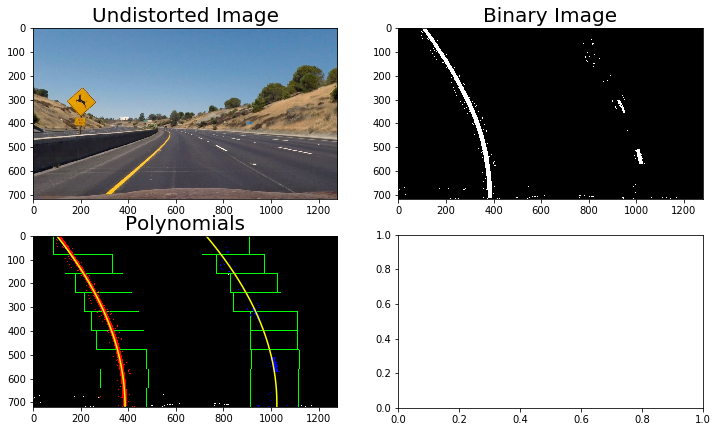

In [89]:
LF.should_plot(True)
result = LF.apply_pipeline(img)

In [79]:
LF.apply_on_video(input_video='project_video.mp4',output_video='project_video_out.mp4')


[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [07:52<00:00,  2.77it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 7min 53s


In [83]:
from IPython.display import HTML
project_output='project_video_output'
HTML("""
<video width="960" height="540" controls>
    <source src="{0}">
</video>
""".format("project_video_out.mp4"))